<a href="https://colab.research.google.com/github/theQuert/iganfun/blob/main/models/GANs_Dog_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Kaggle
[Generative Dog Images](https://www.kaggle.com/jesucristo/gan-introduction)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stimastudio","key":"2c9d6620df96b91558af6d345053c9a0"}'}

In [2]:
!mkdir /content/.kaggle
!mv /content/kaggle.json /content/.kaggle

In [3]:
api_token = {"username":"stimastudio","key":"2c9d6620df96b91558af6d345053c9a0"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.makedirs('/content/Dataset')
os.chdir('/content/Dataset')
# Download Datasets
! kaggle competitions download -c generative-dog-images
 
!ls /kaggle

 99% 735M/739M [00:14<00:00, 48.6MB/s]
100% 739M/739M [00:14<00:00, 51.9MB/s]
 54% 9.00M/16.8M [00:00<00:00, 13.3MB/s]
100% 16.8M/16.8M [00:00<00:00, 24.6MB/s]


In [4]:
!unzip /content/Dataset/all-dogs.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inflating: all-dogs/n02093859_36.

#### Retrieve Datasets from Kaggle

In [5]:
PATH = '/content/Dataset/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

There are 20579 pictures of dogs.


In [6]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils
import torchvision
from torch.autograd import Variable
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
# from tqdm import tqdm_notebook as tqdm
import tqdm.notebook.tqdm as tqdm

In [7]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder('/content/Dataset/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [8]:
# batch_size = 32
# image_size = 64*64
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder('/content/Dataset', transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size = batch_size)
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


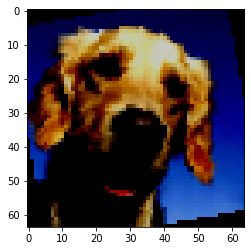

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


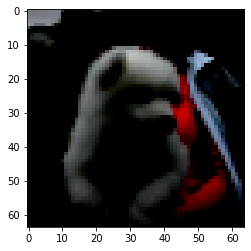

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


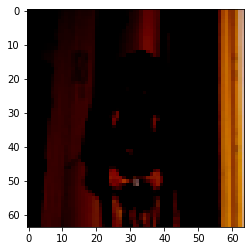

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


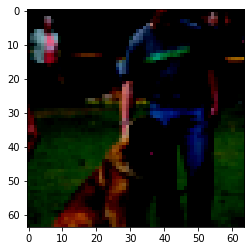

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


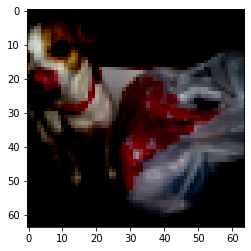

In [9]:
for i in range(5):
  plt.imshow(imgs[i])
  plt.show()

#### Weights

In [10]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

#### Generator

In [20]:
class G(nn.Module):
  def __init__(self):
      super(G, self).__init__()
      self.main = nn.Sequential(
          nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(512),
          nn.ReLU(True),
          nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(True),
          nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
          nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
          nn.Tanh()
      )
  def forward(self, input):
    output = self.main(input)
    return output

# Creating the generator
nn_G = G()
nn_G.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### Discriminator

In [21]:
class D(nn.Module):
  def __init__(self):
    super(D, self).__init__()
    self.main = nn.Sequential(
    nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
    )

  def forward(self, input):
    output = self.main(input)
    # .view(-1) = Flattens the output into 1D instead of 2D
    return output.view(-1)

  # Creating the Discriminator
nn_D = D()
nn_D.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [22]:
class Generator(nn.Module):
  def __init__(self, nz=128, channels=3):
    super(Generator, self).__init__()
    self.nz = nz
    self.channels = channels

    def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
      block = [
               nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, 
                                  padding=padding, bias=False),
               nn.BatchNorm2d(n_output),
      ]
      return block
    self.model = nn.Sequential(
        *convlayer(self.nz, 1024, 4, 1, 0),
        *convlayer(1024, 512, 4, 2, 1),
        *convlayer(512, 256, 4, 2, 1),
        *convlayer(256, 128, 4, 2, 1),
        *convlayer(128, 64, 4, 2, 1),
        nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
        nn.Tanh()
    )
  def forward(self, z):
    z = z.view(-1, self.nz, 1, 1)
    img = self.model(z)
    return img

In [23]:
class Discriminator(nn.Module):
  def __init__(self, channels=3):
    super(Discriminator, self).__init__()
    self.channels = channels
    def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
      block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride,
                         padding=padding, bias=False)]
      if bn:
        block.append(nn.BatchNorm2d(n_output))
      block.append(nn.LeakyReLU(0.2, inplace=True))
      return block
    
    self.model = nn.Sequential(
        *convlayer(self.channels, 32, 4, 2, 1),
        *convlayer(32, 64, 4, 2, 1),
        *convlayer(64, 128, 4, 2, 1, bn=True),
        *convlayer(128, 256, 4, 2, 1, bn=True),
        nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
    )
  def forward(self, imgs):
    logits = self.model(imgs)
    out = torch.sigmoid(logits)
    return out.view(-1, 1)

In [15]:
!mkdir results
!ls

all-dogs  all-dogs.zip	Annotation.zip	results


In [24]:
epochs = 10
lr = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(nn_D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(nn_G.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        nn_D.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = nn_D(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = nn_G(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = nn_D(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        nn_G.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = nn_D(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, epoch, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = nn_G(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

#### Params

In [28]:
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 10

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize models and optimizers

In [29]:
nn_G = Generator(nz).to(device)
nn_D = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(nn_D.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(nn_G.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = [] 

#### Plot loss per epoch

In [30]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [31]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = nn_G(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

#### Training Loop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


[1/10][322/644] Loss_D: 1.3624 Loss_G: 10.1300 D(x): 0.9744 D(G(z)): 0.5694 / 0.0000
[1/10][644/644] Loss_D: 0.9313 Loss_G: 4.9150 D(x): 0.5830 D(G(z)): 0.2431 / 0.0658



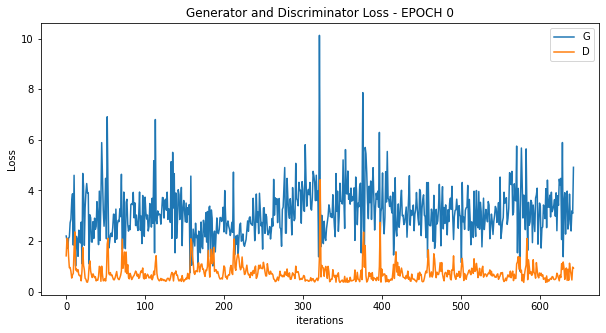

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


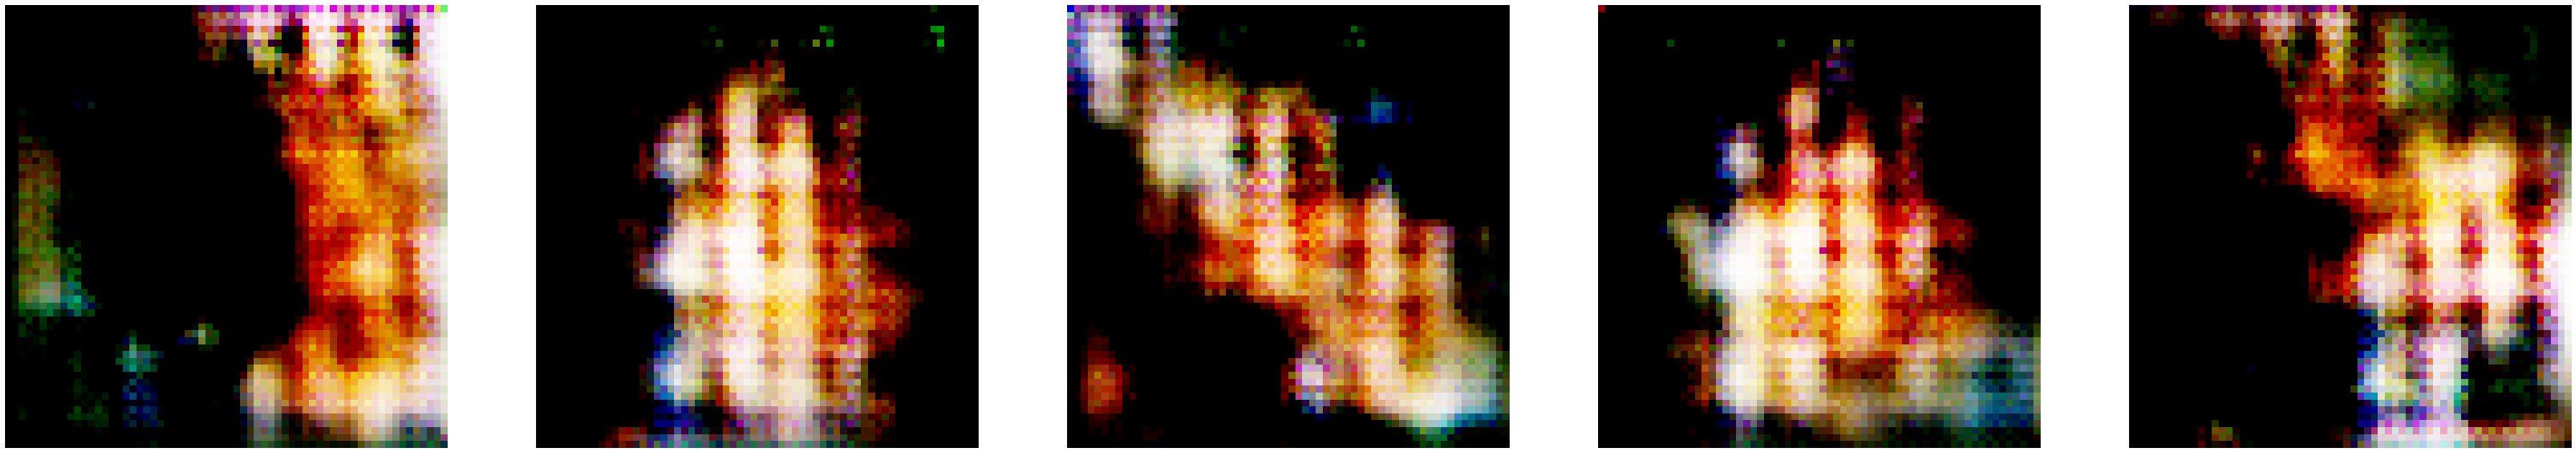

[2/10][322/644] Loss_D: 0.3756 Loss_G: 4.8042 D(x): 0.9373 D(G(z)): 0.0140 / 0.0073
[2/10][644/644] Loss_D: 0.9962 Loss_G: 6.0627 D(x): 0.3597 D(G(z)): 0.0042 / 0.0017



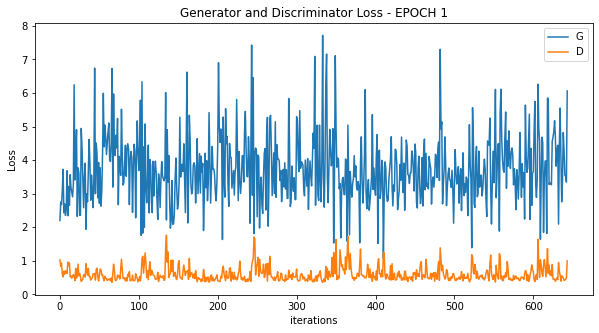

[3/10][322/644] Loss_D: 0.4633 Loss_G: 3.2946 D(x): 0.9491 D(G(z)): 0.0654 / 0.0352
[3/10][644/644] Loss_D: 0.7130 Loss_G: 2.8039 D(x): 0.5223 D(G(z)): 0.0026 / 0.0479



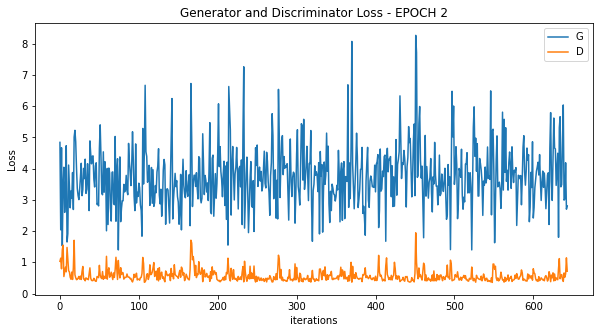

[4/10][322/644] Loss_D: 0.4538 Loss_G: 4.3408 D(x): 0.8432 D(G(z)): 0.0221 / 0.0153
[4/10][644/644] Loss_D: 4.9127 Loss_G: 1.1164 D(x): 0.0073 D(G(z)): 0.2999 / 0.3272



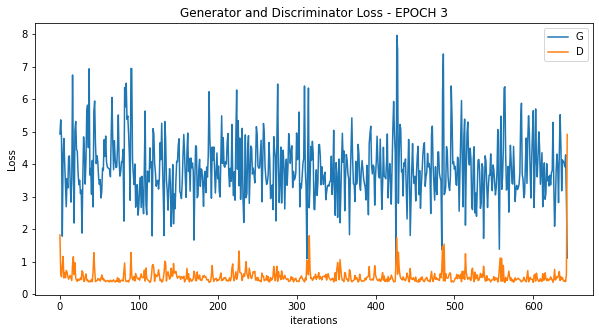

[5/10][322/644] Loss_D: 0.4285 Loss_G: 3.6216 D(x): 0.8473 D(G(z)): 0.0393 / 0.0264
[5/10][644/644] Loss_D: 0.9803 Loss_G: 1.1756 D(x): 0.4764 D(G(z)): 0.0029 / 0.3511



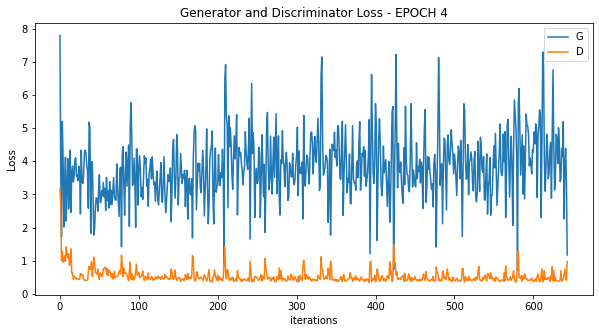

[6/10][322/644] Loss_D: 0.4877 Loss_G: 6.2982 D(x): 0.7438 D(G(z)): 0.0022 / 0.0013
[6/10][644/644] Loss_D: 0.4632 Loss_G: 3.0066 D(x): 0.7184 D(G(z)): 0.0146 / 0.0396



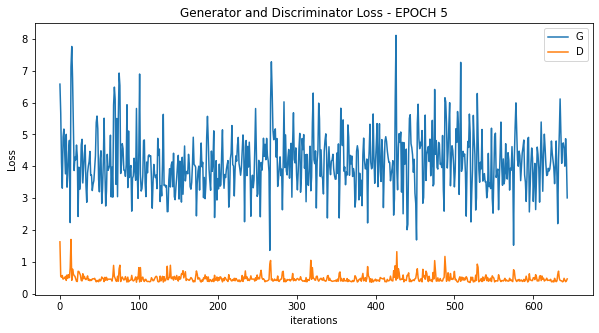

[7/10][322/644] Loss_D: 0.3962 Loss_G: 4.8861 D(x): 0.8890 D(G(z)): 0.0530 / 0.0062
[7/10][644/644] Loss_D: 0.3969 Loss_G: 4.9990 D(x): 0.8722 D(G(z)): 0.0038 / 0.0040



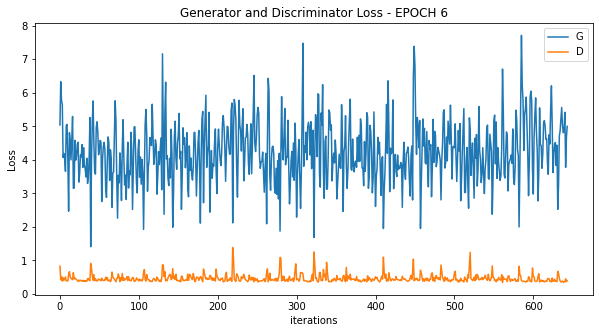

[8/10][322/644] Loss_D: 0.3626 Loss_G: 4.7648 D(x): 0.8753 D(G(z)): 0.0128 / 0.0073
[8/10][644/644] Loss_D: 2.5603 Loss_G: 2.8366 D(x): 0.3581 D(G(z)): 0.0000 / 0.0472



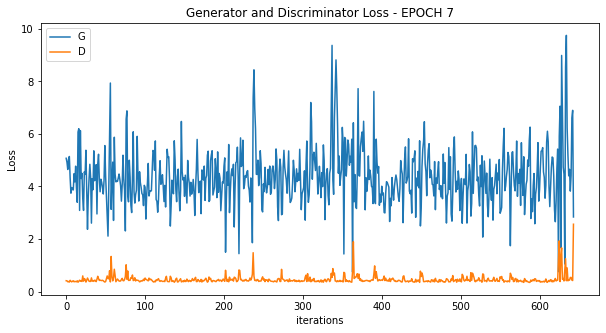

[9/10][322/644] Loss_D: 0.4461 Loss_G: 3.6172 D(x): 0.8549 D(G(z)): 0.0428 / 0.0237
[9/10][644/644] Loss_D: 0.3806 Loss_G: 4.8779 D(x): 0.8748 D(G(z)): 0.0492 / 0.0048



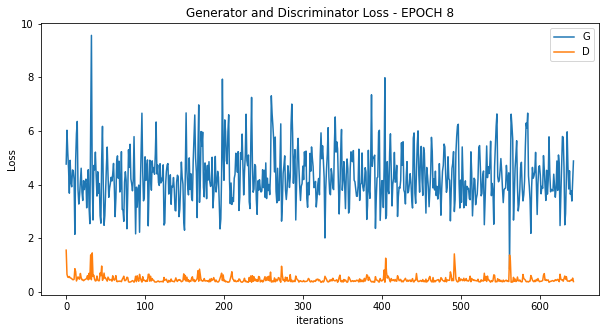

[10/10][322/644] Loss_D: 0.4036 Loss_G: 3.9354 D(x): 0.8353 D(G(z)): 0.0184 / 0.0171
[10/10][644/644] Loss_D: 0.9550 Loss_G: 1.1148 D(x): 0.4159 D(G(z)): 0.0289 / 0.3226



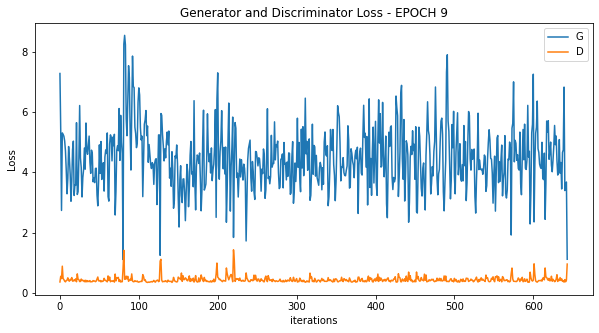

In [32]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train withreal
        nn_D.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = nn_D(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()
        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = nn_G(noise)
        labels.fill_(fake_label)
        output = nn_D(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        nn_G.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = nn_D(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)